# Lassa data set evaluation

In [35]:
import pandas as pd
import matplotlib.pyplot as plt


Data ingestion. We also compute the edit distance in relation to the sequence length and the sequence length in relation to the reference length

In [36]:
fname_stats = "../data/lassa/collected_stats.tsv"
seqstats = pd.read_csv(fname_stats, sep='\t')
seqstats['RelativeLength'] = seqstats['Length'] / seqstats['ReferenceLength']
seqstats['RelativeError'] = seqstats['EditDistance'] / seqstats['Length']
seqstats

,Sequence,N_share,Length,Orientation,Reference,EditDistance,ReferenceLength,RelativeLength,RelativeError
0,AY179171.1,0.0,7227,forward,FR832710.1,0.0,7267.0,0.994496,0.000000
1,FR832710.1,0.0,7267,forward,FR832710.1,0.0,7267.0,1.000000,0.000000
2,GU573541.1,0.0,754,reverse,FR832710.1,92.0,7267.0,0.103757,0.122016
3,GU573542.1,0.0,754,reverse,FR832710.1,91.0,7267.0,0.103757,0.120690
4,GU573543.1,0.0,754,reverse,FR832710.1,91.0,7267.0,0.103757,0.120690
...,...,...,...,...,...,...,...,...,...
2945,LC388587.1,0.0,281,unmapped,NaN,NaN,NaN,NaN,NaN
2946,LC388588.1,0.0,281,unmapped,NaN,NaN,NaN,NaN,NaN
2947,LC388589.1,0.0,281,unmapped,NaN,NaN,NaN,NaN,NaN
2948,MT119502.1,0.0,223,unmapped,NaN,NaN,NaN,NaN,NaN


In [37]:
seqstats[seqstats['Orientation'] == 'unmapped']

,Sequence,N_share,Length,Orientation,Reference,EditDistance,ReferenceLength,RelativeLength,RelativeError
2933,HM143866.1,0.0,237,unmapped,NaN,NaN,NaN,NaN,NaN
2934,HM143867.1,0.0,234,unmapped,NaN,NaN,NaN,NaN,NaN
2935,HM143876.1,0.0,234,unmapped,NaN,NaN,NaN,NaN,NaN
2936,HM143879.1,0.0,234,unmapped,NaN,NaN,NaN,NaN,NaN
2937,JN651370.1,0.0,237,unmapped,NaN,NaN,NaN,NaN,NaN
2938,JN651374.1,0.0,234,unmapped,NaN,NaN,NaN,NaN,NaN
2939,JN651382.1,0.0,234,unmapped,NaN,NaN,NaN,NaN,NaN
2940,JN651388.1,0.0,234,unmapped,NaN,NaN,NaN,NaN,NaN
2941,JN651389.1,0.0,234,unmapped,NaN,NaN,NaN,NaN,NaN
2942,JN651395.1,0.0,234,unmapped,NaN,NaN,NaN,NaN,NaN


array([[<Axes: title={'center': 'N_share'}>,
        <Axes: title={'center': 'Length'}>],
       [<Axes: title={'center': 'RelativeLength'}>,
        <Axes: title={'center': 'RelativeError'}>]], dtype=object)

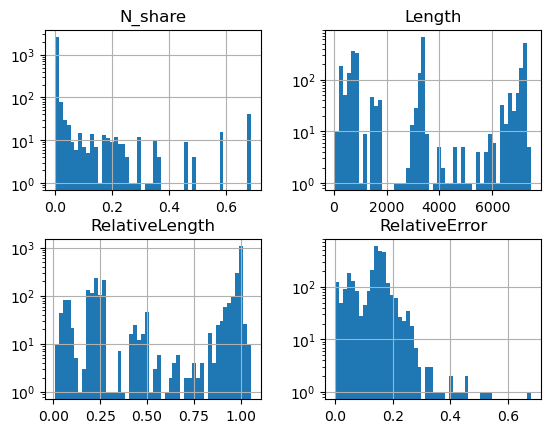

In [38]:
seqstats[['N_share', 'Length', 'RelativeLength', 'RelativeError']].hist(bins=50, log=True)

We remove all sequences that are too short or have a too high share of Ns.

In [43]:
minlen = 2000
max_n_share = 0.1 

print('Total:', len(seqstats))
print('Unmapped:', len(seqstats[seqstats['Orientation'] == 'unmapped']))
print(f'N-share larger than {max_n_share}:', len(seqstats[seqstats['N_share'] > max_n_share]))
print(f'Length smaller than {minlen}:', len(seqstats[seqstats['Length'] < minlen]))

seqstats_high_coverage = seqstats[
    (seqstats['N_share'] <= max_n_share)
    & (seqstats['Length'] >= minlen)
    & (seqstats['Orientation'] != 'unmapped')
]
print('After filtering:', len(seqstats_high_coverage))

Total: 2950
Unmapped: 17
N-share larger than 0.1: 198
Length smaller than 2000: 1186
After filtering: 1579


Lets look at the relative length and error statistics.

array([[<Axes: title={'center': 'RelativeLength'}>,
        <Axes: title={'center': 'RelativeError'}>]], dtype=object)

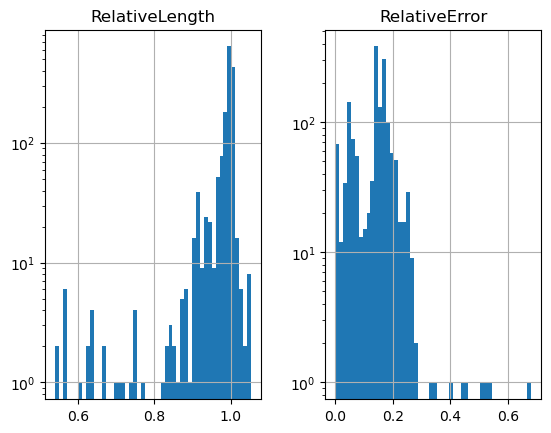

In [44]:
seqstats_high_coverage[['RelativeLength', 'RelativeError']].hist(bins=50, log=True)

Lets remove all sequences with a relative length below 0.8.

In [51]:
min_relative_length = 0.8
seqstats_target_covered = seqstats_high_coverage[seqstats_high_coverage['RelativeLength'] > min_relative_length]

And look again at the error distribution.

array([[<Axes: title={'center': 'RelativeError'}>]], dtype=object)

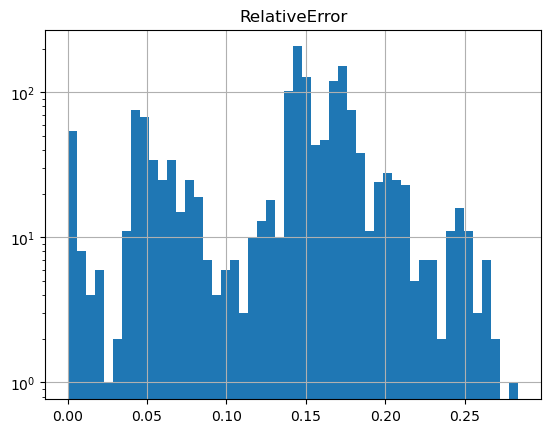

In [58]:
seqstats_target_covered[['RelativeError']].hist(bins=50, log=True)

In [62]:
seqstats_target_covered.nlargest(5, 'RelativeError')


,Sequence,N_share,Length,Orientation,Reference,EditDistance,ReferenceLength,RelativeLength,RelativeError
2793,MH053466.1,0.046136,7001,forward,OL774860.1,1988.0,7170.0,0.976430,0.283959
2828,MK117905.1,0.021283,7001,forward,OL774860.1,1878.0,7170.0,0.976430,0.268247
2823,MK107886.1,0.011002,7362,forward,OL774860.1,1969.0,7170.0,1.026778,0.267454
2829,MK117924.1,0.031058,7148,forward,OL774860.1,1906.0,7170.0,0.996932,0.266648
2816,MK107876.1,0.011920,7215,forward,OL774860.1,1901.0,7170.0,1.006276,0.263479


TODO: create a list with forward and reverse reads for 